# FICO Quantization 
### With K-Means Quantization + DP Theory + Tiny DP Demo

## 1. Load Data

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('C:/Users/hamid/Downloads/Loan_Data.csv')
df = df[['fico_score','default']].dropna()
df_sorted = df.sort_values('fico_score').reset_index(drop=True)

fico = df_sorted['fico_score'].values
default = df_sorted['default'].values
N = len(df_sorted)

df.head()


,fico_score,default
0,605,0
1,572,1
2,602,0
3,612,0
4,631,0


## 2. FICO Distribution

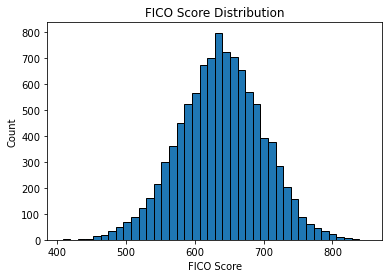

In [3]:

plt.hist(df['fico_score'], bins=40, edgecolor='black')
plt.title("FICO Score Distribution")
plt.xlabel("FICO Score")
plt.ylabel("Count")
plt.show()


## 3. Default Rate vs FICO (Smoothed)

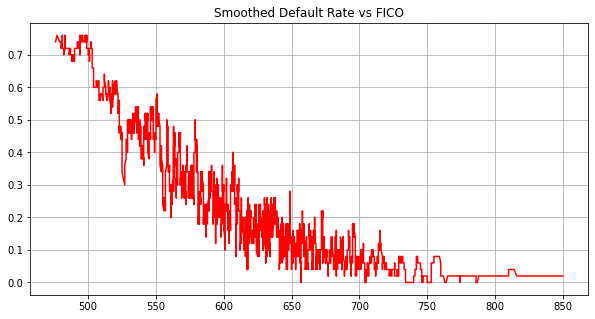

In [5]:

window = 50
df_sorted['rolling_pd'] = df_sorted['default'].rolling(window).mean()
mask = df_sorted['rolling_pd'].notna()

plt.figure(figsize=(10,5))
plt.plot(df_sorted['fico_score'].values, df_sorted['rolling_pd'].values, color='red')
plt.title("Smoothed Default Rate vs FICO")
plt.grid()
plt.show()


## 4. K-Means Quantization (Main Working Method)

In [6]:

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

def kmeans_quantization(df, max_k=10):
    X = df[['fico_score']].values
    results = []
    for k in range(2, max_k+1):
        km = KMeans(n_clusters=k, random_state=42).fit(X)
        mse = mean_squared_error(X, km.cluster_centers_[km.labels_])
        aic = len(df)*np.log(mse) + 2*k
        bic = len(df)*np.log(mse) + k*np.log(len(df))
        results.append((k, mse, aic, bic, km))
    return results

kmeans_results = kmeans_quantization(df_sorted)
[k[:4] for k in kmeans_results[:5]]


[(2, 1349.300718467207, 72077.41750910628, 72091.83818985023),
 (3, 706.1175936243108, 65603.8178683037, 65625.44888941963),
 (4, 439.2692116785116, 60859.124635689455, 60887.96599717736),
 (5, 298.5909680406373, 57000.746369605375, 57036.79807146526),
 (6, 216.0034597423194, 53764.94424881441, 53808.20629104627)]

### Visual — K-Means Selection Metrics

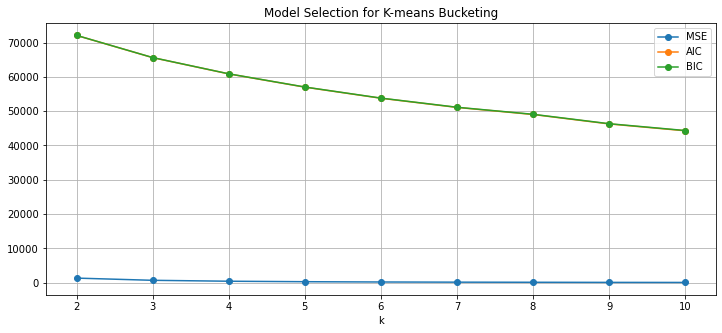

In [7]:

k_vals = [r[0] for r in kmeans_results]
mse_vals = [r[1] for r in kmeans_results]
aic_vals = [r[2] for r in kmeans_results]
bic_vals = [r[3] for r in kmeans_results]

plt.figure(figsize=(12,5))
plt.plot(k_vals, mse_vals, marker='o', label='MSE')
plt.plot(k_vals, aic_vals, marker='o', label='AIC')
plt.plot(k_vals, bic_vals, marker='o', label='BIC')
plt.legend(); plt.grid()
plt.title("Model Selection for K-means Bucketing")
plt.xlabel("k")
plt.show()


# 5. Dynamic Programming Log-Likelihood (Theory Only)


DP finds optimal bucket boundaries by maximizing:

\[
LL = \sum_{i=1}^{B} \big[ k_i \, \ln(p_i) + (n_i - k_i)\ln(1 - p_i) \big]
\]

But full DP is **O(N²–N³)** and not feasible on large datasets.

Below is a **tiny demo** on a small sample (20 rows).


In [8]:

# Tiny DP Example (20 rows only)
df_small = df_sorted.iloc[:20].copy()
fico_s = df_small['fico_score'].values
default_s = df_small['default'].values
Ns = len(df_small)

prefix_k = np.cumsum(default_s)

def seg(i,j):
    n = j-i+1
    k = prefix_k[j] - (prefix_k[i-1] if i>0 else 0)
    return n,k

def ll(n,k):
    p = k/n if n>0 else 0.00001
    if p<=0 or p>=1: return -1e9
    return k*np.log(p)+(n-k)*np.log(1-p)

DP = np.full((Ns, Ns), -1e12)
prev = np.full((Ns, Ns), -1)

# 1 bucket
for j in range(Ns):
    n,k = seg(0,j)
    DP[0,j] = ll(n,k)

# DP small
for b in range(1, Ns):
    for j in range(b, Ns):
        best=-1e12; best_i=-1
        for i in range(b-1, j):
            n,k = seg(i+1,j)
            score = DP[b-1,i] + ll(n,k)
            if score>best:
                best=score; best_i=i
        DP[b,j]=best; prev[b,j]=best_i

best_b = int(np.argmax([DP[b,Ns-1] for b in range(Ns)]))

# Recover boundaries
bounds=[]
j=Ns-1
for b in range(best_b,-1,-1):
    bounds.append(j)
    j=prev[b,j]
    if j<0: break

sorted(bounds)


[6, 10, 16, 19]

## 6. Final Useable Functions (K-Means Only)

In [9]:

def bucket_fico_mse(score, km):
    centers = km.cluster_centers_.flatten()
    idx = np.argmin(abs(centers - score))
    return idx
